# Optimización de funciones de una variable

## Objetivo: Mostrar las ventajas del uso de algoritmos genéticos como herramientas de optimización de funciones.
### Para mayor claridad, se muestran funciones de una variable. El método es facilmente generalizable.
### La meta de este ejercicio es reproducir los resultados del artículo de Dezdemona Gjylapi y Vladimir Kasëmi: 
[The Genetic Algorithm for finding the maxima of single-variable functions](https://www.researchgate.net/publication/309616654_The_Genetic_Algorithm_for_finding_the_maxima_of_single-variable_functions)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import random


# Importamos los módulos relevantes de la libreria de algoritmos evolutivos 

from deap import base, creator, tools, algorithms

# Importamos este módulo independiente para implementar elitismo, adjunto en la carpeta fuente. 

import elitism

### Definimos cada una de las funciones trabajadas en el artículo de Gjylapi:

In [3]:
def polynomial(x):
    y =  - x**6/60 - x**5/50 + x**4/2 + 2*x**3/3 - 3.2*x**2 - 6.4*x
    return y

def rational(x):
    y = -(x**6 + x**5 - 10*x**2 - 10*x - 12)/(x**2 + 6)
    return y

def irrational(x):
    y = 5 - np.sqrt(x**4 + 2*x**3 - 3*x**2 + 13)
    return y

def trigonometric(x):
    y =  np.sin(3*x + 45)**2 + 0.9*np.sin(9*x)**3 - np.sin(15*x + 50) - np.cos(2*x - 30)
    return y

def asymptoteV(x):
    if -0.05 <= x <= 0.05:   # Para evitar la discontinuidad, definimos un valor "razonable"
        y = 0
    else:
        y = (np.sin(2*np.pi*x) - np.cos(3*np.pi*x))/x
    return y

def asymptoteH(x):
    if -0.05 <= x <= 0.05:  
        y = -16               # Para evitar la discontinuidad
    else:
        y = (2*x - 1)/(x**2)
    return y

def logarithmic(x):
    y = -x**4*(np.log(abs(x)) - 1)
    return y

def exponential(x):
    if -0.01 <= x <= 0.01:
        y = -10                 # Para evitar la discontinuidad
    else:
        y = np.exp(-x)*(np.log(abs(x)) + x/(abs(x)))
    return y

### Elegir una de las funciones de la celda anterior, graficar, optimizar y analizar

In [4]:
fun = np.vectorize(lambda x: polynomial(x)) # Elegir alguna función de arriba.

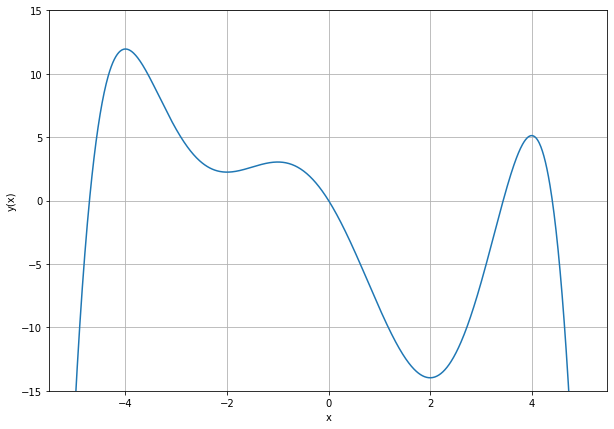

In [5]:
xs = np.arange(-5.0, 5.0, 0.01) # Ajustar el dominio de la función según se ve en el artículo

plt.figure(figsize=(10, 7))
plt.grid(True)
plt.xlabel("x")
plt.ylim(-15, 15) # Ajustar los límites para que luzca como en el artículo
plt.ylabel("y(x)")
plt.plot(xs, fun(xs))
plt.show()

### Primero usemos el método minimize de scipy para optimizar la función, y comprobemos su desempeño

In [6]:
x = 0  # Este valor inicial se puede modificar. Se sugiere cambiarlo para experimentar.
result = minimize(fun, x, bounds = [(-4., 4.)]) # Ajustar los límites, según la función a trabajar.
x_min = result.x
y_min = result.fun

print("Convergencia: ", result.success)
print("X_min = ", x_min)
print("Y_min = ", y_min)

# El método anterior sirve para obtener el mínimo. ¿Cómo obtenemos el máximo de la función?

Convergencia:  True
X_min =  [2.]
Y_min =  [-13.97333333]


## Algoritmos Genéticos

### Aquí usamos la librería DEAP para implementar lo optimización con un algoritmo genético.
#### Al cambiar de función, se deben ajustar las fronteras y actualizar la celda de evaluación de la función (señalada abajo)

In [7]:
# Constantes del problema:
DIMENSIONS = 1  # Número de dimensiones 
BOUND_LOW, BOUND_UP = -4.0, 4.0  # Ajustar los límites de la variable independiente

In [8]:
# Parámetros del algoritmo:
POPULATION_SIZE = 10 # A mayor cantidad, mejor desempeño pero mayor cómputo
P_CROSSOVER = 0.8  # Probabilidad de cruza: 0.8 es valor típico
P_MUTATION = 0.3   # Probabilidad de mutación individual, puede ser entre 0.1 y 0.5.
MAX_GENERATIONS = 50  # A mayor cantidad, mejor desempeño pero mayor cómputo
HALL_OF_FAME_SIZE = 1 # Cantidad de mejores individuos que pasan íntegramente a la siguiente generación 
CROWDING_FACTOR = 20.0  # factor no relevante en todas las técnicas

In [10]:
# Para fijar la población inicial:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

### Esta es la herramienta base

In [11]:
toolbox = base.Toolbox() # Herramienta estructural de DEAP

### Las siguientes instrucciones generales crean nuevas clases en DEAP. (Correr una sola vez para evitar dificultades)

#### En la siguiente celda se debe elegir la opción de buscar máximo o mínimo de la función

In [12]:
# Define la estrategia de optimización:
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Para hallar máximo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Para hallar mínimo

#### Esta celda debe ser compatible con la elección anterior

In [13]:
# Crea la clase individuos:
#creator.create("Individual", list, fitness=creator.FitnessMax)
creator.create("Individual", list, fitness=creator.FitnessMin)

### La siguiente es una instrucción especifica para la optimización númerica

In [14]:
# Crea poblaciones como números aleatorios distribuidos en la cantidad de dimensiones especificadas
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

### Las siguientes son instrucciones generales

In [15]:
# Crea un flotante a partir de lo anterior.
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

In [16]:
# Crea un individo, a partir de lo anterior.
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

In [17]:
# Crea una población de individuos:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

#### Actualizar la siguiente celda cada que se elija una nueva función

In [18]:
# Evalua la función elegida
toolbox.register("evaluate", fun) # Actualizar esta celda cada que se elija una nueva función

In [19]:
# Operadores genéticos:
toolbox.register("select", tools.selTournament, tournsize=2) # Selección por torneo de tamaño 2
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, 
                 eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

### Flujo principal del algoritmo genetico

#### La herramienta "stats" guarda registro de valores máximo, mínimo y promedio en cada generación. Se puede guardar y mostrar todo, si se desea.

In [20]:
def main():

    # Crea la población inicial (generación 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # Guarda datos estadísticos:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
#    stats.register("max", np.max)   # Elegir cuando se busque maximizar
    stats.register("min", np.min)   # Elegir cuando se desee minimizar
    stats.register("avg", np.mean)

    # Define el Salón de la fama para implementar elitismo:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Incorpora elitismo en el AG:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # Imprime la mejor solución encontrada:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # Estrae los datos estadísticos:
    gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")

    return population, logbook, hof

### Acttivar esta celda cada que se desee correr de nuevo el AG.

#### Se debe elegir si se quiere graficar la evolución del máximo o del mínimo. 
#### También se puede elegir mostrar el promedio, pero no siempre es adecuado.
#### Best Individual es el valor de la variable donde se encuentra el óptimo global de la función y Best Fitness, su valor.

gen	nevals	min     	avg     
0  	10    	-13.8906	-0.16872
1  	9     	-13.8906	-4.32709
2  	5     	-13.9725	-7.46178
3  	4     	-13.9725	-11.3487
4  	8     	-13.9725	-13.1286
5  	8     	-13.9725	-13.5948
6  	7     	-13.9725	-13.6901
7  	8     	-13.9725	-13.7463
8  	4     	-13.9725	-13.5102
9  	7     	-13.9731	-13.6467
10 	6     	-13.9731	-13.9003
11 	6     	-13.9731	-13.6631
12 	7     	-13.9731	-13.9589
13 	4     	-13.9731	-13.7782
14 	8     	-13.9731	-13.8813
15 	6     	-13.9731	-13.6258
16 	8     	-13.9731	-13.8822
17 	7     	-13.9731	-13.5454
18 	7     	-13.9731	-13.7298
19 	8     	-13.9731	-13.9684
20 	7     	-13.9731	-13.6653
21 	7     	-13.9731	-13.5094
22 	8     	-13.9731	-13.0511
23 	7     	-13.9731	-13.837 
24 	8     	-13.9731	-13.1265
25 	7     	-13.9731	-13.2254
26 	6     	-13.9731	-13.2626
27 	7     	-13.9731	-13.7669
28 	7     	-13.9731	-13.7612
29 	8     	-13.9731	-13.7368
30 	9     	-13.9733	-13.4244
31 	7     	-13.9733	-12.9109
32 	8     	-13.9733	-13.1098
33 	8     	-13

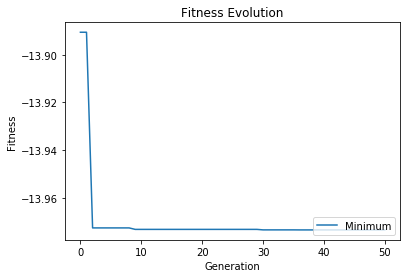

In [21]:
# Llama al flujo principal y muestra los resultados

pop, log, hof = main()

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

best = hof.items[0]

plt.figure()
plt.plot(gen, min_, label="Minimum") # Elegir para mostrar la evolución del mejor fitness al minimizar
#plt.plot(gen, max_, label="Maximum") # Elegir para mostrar la evolución del mejor fitness al maxmizar
#plt.plot(gen, avg, label="Average") # Elegir para mostrar la evolución del promedio del fitness
plt.title("Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

### Comparar con lo que da minimize.scipy